# Lab 2: Evaluating and Improving the Campus Event Agent

**Objective**: Systematically evaluate and improve agent performance using Azure AI Evaluation SDK

## What You'll Learn

- Create structured test datasets with expected outcomes
- Use Azure AI evaluators (Relevance, Task Adherence)
- Build custom code-based evaluators (Conciseness)
- Convert agent responses to trace format
- Run baseline evaluations
- Improve agents based on metrics
- Measure improvement quantitatively

## Key Concept: Evaluation-Driven Development

Just like Test-Driven Development (TDD):
1. **Create tests** (evaluation dataset)
2. **Measure baseline** (current performance)
3. **Improve** (fix identified issues)
4. **Re-measure** (verify improvement)

---

## Part A: Setup & Rebuild Agent

We'll rebuild a baseline version of the agent from Lab 1 with intentional issues.

In [1]:
# Install all Microsoft Agents Framework
!pip install -q agent-framework --pre

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.9/217.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.4/357.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Install Azure AI Evaluation SDK
!pip install -q azure-ai-evaluation matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 13.2 MB/s eta 0:00:00


In [34]:
# Import libraries
from google.colab import userdata
from agent_framework import ChatAgent
from agent_framework.openai import OpenAIChatClient
from typing import Annotated, List, Dict, Any
from pydantic import Field
import requests
import sys
import json
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('/content')

print("✅ Libraries imported")

✅ Libraries imported


In [14]:
# Download utils.py helper functions
!wget -q https://raw.githubusercontent.com/tezansahu/building-eval-driven-ai-agents/main/labs/utils.py -O utils.py

from utils import print_agent_response, function_to_tool_schema, convert_agent_response_to_trace


In [5]:
# Load configuration
GITHUB_PAT = userdata.get('GITHUB_PAT')
BACKEND_URL = ""  # TODO: Paste your ngrok URL from Lab 0

if not BACKEND_URL:
    print("⚠️ Set BACKEND_URL!")
else:
    print("✅ Configuration loaded")

✅ Configuration loaded


### Build Baseline Agent (Intentionally Has Issues)

This agent has problems we'll identify through evaluation:
- Tool responses are too brief (no event details, no emojis)
- Instructions are minimal
- No conciseness guidelines

In [6]:
# Baseline tools (brief responses - intentionally lacking detail)

def get_events() -> str:
    """Retrieve all campus events."""
    try:
        response = requests.get(f"{BACKEND_URL}/events")
        events = response.json()
        return f"Found {len(events)} events: {','.join([event['name'] for event in events])}" if events else "No events"
    except Exception as e:
        return f"Error: {str(e)}"

In [7]:
def get_event_details(
    event_id: Annotated[str, Field(description="Event ID")]
) -> str:
    """Get event details."""
    try:
        response = requests.get(f"{BACKEND_URL}/events/{event_id}")
        if response.status_code == 404:
            return "Event not found"
        event = response.json()
        return f"{event['name']} on {event['date']}"
    except Exception as e:
        return f"Error: {str(e)}"

In [8]:
def register_for_event(
    student_id: Annotated[str, Field(description="Student ID")],
    event_id: Annotated[str, Field(description="Event ID")],
    student_name: Annotated[str, Field(description="Student name")]
) -> str:
    """Register student for event."""
    try:
        response = requests.post(
            f"{BACKEND_URL}/events/{event_id}/register",
            json={"student_id": student_id, "student_name": student_name}
        )
        result = response.json()
        return "Registered" if result.get("success") else f"Failed: {result.get('message')}"
    except Exception as e:
        return f"Error: {str(e)}"

In [9]:
def get_event_participants(
    event_id: Annotated[str, Field(description="Event ID")]
) -> str:
    """Get event participants."""
    try:
        response = requests.get(f"{BACKEND_URL}/events/{event_id}/participants")
        if response.status_code == 404:
            return "Event not found"
        data = response.json()
        count = data.get('participant_count', 0)
        return f"{count} participants"
    except Exception as e:
        return f"Error: {str(e)}"

In [10]:
BASELINE_INSTRUCTIONS = "You are a campus event assistant. Help students with events."

In [11]:
chat_client = OpenAIChatClient(
    model_id="gpt-4o-mini",
    api_key=GITHUB_PAT,
    base_url="https://models.github.ai/inference"
)

In [12]:
# Baseline agent (minimal instructions)
baseline_agent = ChatAgent(
    chat_client=chat_client,
    instructions=BASELINE_INSTRUCTIONS,
    tools=[get_events, get_event_details, register_for_event, get_event_participants]
)

print("✅ Baseline agent created")

✅ Baseline agent created


In [15]:
# Quick test
test_response = await baseline_agent.run(
    "What events are happening on campus?"
)
print_agent_response(test_response, show_details=True)

AGENT RESPONSE

Here are the events happening on campus:

1. **TechFest 2024**
2. **Spring Hackathon 2024**
3. **AI & Machine Learning Workshop**
4. **Robotics Club Demo Day**

Let me know if you need more details about any of these events!


------------------------------------------------------------
DETAILS
------------------------------------------------------------

🔧 Tool Calls Made: 1
  1. get_events()


## Part B: Create Test Dataset

A good test dataset includes:
- Diverse query types
- Expected tools to be called
- Expected outcomes
- Coverage of all capabilities

In [52]:
# For this walkthrough, we'll use 5 diverse queries covering key capabilities
# Later, you can uncomment more test cases to expand your evaluation coverage

test_dataset = [
    {
        "query": "What events are happening on campus?",
        "expected_tool": "get_events",
        "expected_outcome": "Should call get_events to list all available events",
        "category": "browse"
    },
    # {
    #     "query": "Show me all the upcoming events",
    #     "expected_tool": "get_events",
    #     "expected_outcome": "Should browse events and present formatted list",
    #     "category": "browse"
    # },
    {
        "query": "Tell me more about the AI Workshop",
        "expected_tool": "get_event_details",
        "expected_outcome": "Should get detailed information about specific event",
        "category": "details"
    },
    # {
    #     "query": "What's TechFest 2024 about?",
    #     "expected_tool": "get_event_details",
    #     "expected_outcome": "Should retrieve event description, date, venue, capacity",
    #     "category": "details"
    # },
    {
        "query": "Register me for the AI Workshop. My name is Rahul and ID is S001",
        "expected_tool": "register_for_event",
        "expected_outcome": "Should register student with confirmation details",
        "category": "registration"
    },
    # {
    #     "query": "I want to sign up for TechFest 2024. I'm Priya, student ID S002",
    #     "expected_tool": "register_for_event",
    #     "expected_outcome": "Should extract name, ID and register for event",
    #     "category": "registration"
    # },
    {
        "query": "Who's registered for the AI Workshop?",
        "expected_tool": "get_event_participants",
        "expected_outcome": "Should list all registered participants",
        "category": "participants"
    },
    # {
    #     "query": "How many people signed up for TechFest?",
    #     "expected_tool": "get_event_participants",
    #     "expected_outcome": "Should get participant count and list",
    #     "category": "participants"
    # },
    # {
    #     "query": "Show me events, then tell me about the AI Workshop, and register me as Amit (S003)",
    #     "expected_tool": "get_events",
    #     "expected_outcome": "Should execute multi-step workflow: browse → details → register",
    #     "category": "multi-step"
    # },
    {
        "query": "What can you help me with?",
        "expected_tool": None,
        "expected_outcome": "Should respond without calling tools, explain capabilities",
        "category": "information"
    }
]

print(f"✅ Test dataset: {len(test_dataset)} cases")
for cat in set(t['category'] for t in test_dataset):
    count = sum(1 for t in test_dataset if t['category'] == cat)
    print(f"   - {cat}: {count}")

✅ Test dataset: 5 cases
   - registration: 1
   - participants: 1
   - information: 1
   - browse: 1
   - details: 1


## Part C: Build Evaluators

We'll use:
1. **RelevanceEvaluator** (Azure AI) - Is response relevant?
2. **TaskAdherenceEvaluator** (Azure AI) - Did agent follow expected workflow?
3. **ConcisenessEvaluator** (Custom) - Is response under word limit?

In [17]:
# Import Azure AI evaluators
from azure.ai.evaluation import RelevanceEvaluator, TaskAdherenceEvaluator

In [23]:
# Initialize evaluators
# Note: These use Azure OpenAI by default, but we can configure for GitHub Models

# For this workshop, we'll create model config
model_config = {
    "type": "openai",
    "api_key": GITHUB_PAT,
    "model": "openai/gpt-4o-mini",
    "base_url": "https://models.github.ai/inference"
}

In [24]:
relevance_eval = RelevanceEvaluator(model_config)
task_adherence_eval = TaskAdherenceEvaluator(model_config)

print("✅ Azure AI evaluators initialized")

✅ Azure AI evaluators initialized


In [31]:
# Custom Conciseness Evaluator (code-based)
# Following: https://learn.microsoft.com/en-us/azure/ai-foundry/concepts/evaluation-evaluators/custom-evaluators#code-based-evaluators

class ConcisenessEvaluator:
    """
    Custom code-based evaluator for response conciseness.

    Checks if agent response is under a word limit (default: 50 words).
    This is a deterministic, rule-based evaluator.
    """

    def __init__(self, max_words: int = 50):
        self.max_words = max_words

    def __call__(self, *, response: str, **kwargs) -> Dict[str, Any]:
        """
        Evaluate conciseness of response.

        Args:
            response: The agent's response text

        Returns:
            Dict with 'conciseness' score (0 or 1) and 'conciseness_reason'
        """
        # TODO: Implement word counting logic
        # Hint: Use len(response.split())
        # Hint: Return score 1 if under limit, 0 if over

        word_count = len(response.split())
        score = 1 if word_count <= self.max_words else 0

        return {
            "conciseness": score,
            "conciseness_reason": f"{word_count} words ({'✓' if score == 1 else '✗'} limit: {self.max_words})"
        }

conciseness_eval = ConcisenessEvaluator(max_words=50)
print("✅ Custom Conciseness evaluator created")

✅ Custom Conciseness evaluator created


<details>
<summary><b>Solution</b></summary>
  
```python
def __call__(self, *, response: str, **kwargs) -> Dict[str, Any]:
        """
        Evaluate conciseness of response.
        
        Args:
            response: The agent's response text
            
        Returns:
            Dict with 'conciseness' score (0 or 1) and 'reasoning'
        """        
        word_count = len(response.split())
        score = 1 if word_count <= self.max_words else 0
        
        return {
            "conciseness": score,
            "reasoning": f"{word_count} words ({'✓' if score == 1 else '✗'} limit: {self.max_words})"
        }
```
</details>

### Test the Evaluators

In [26]:
test_query = "What events are happening on campus?"
test_response = "You've been registered for the AI & Machine Learning Workshop on 2024-03-25 at 10 AM in Seminar Hall A."

In [29]:
# Test 1: Relevance Evaluator
print("\n1️⃣ RELEVANCE EVALUATOR")
print("   Checks if response answers the query")
rel_result = relevance_eval(query=test_query, response=test_response)
print(f"   Score: {rel_result.get('relevance', 0)}")
print(f"   Reasoning: {rel_result.get('relevance_reason', 'N/A')}")


1️⃣ RELEVANCE EVALUATOR
   Checks if response answers the query
   Score: 3.0
   Reasoning: The response provides specific information about a workshop, which is an event on campus. However, it does not address the user's broader inquiry about all events happening on campus, making it only partially relevant.


In [32]:
# Test 2: Conciseness Evaluator
print("\n2️⃣ CONCISENESS EVALUATOR")
print("   Checks if response is under word limit")
conc_result = conciseness_eval(response=test_response)
print(f"   Score: {conc_result.get('conciseness', 0)}")
print(f"   Reasoning: {conc_result.get('conciseness_reason', 'N/A')}")


2️⃣ CONCISENESS EVALUATOR
   Checks if response is under word limit
   Score: 1
   Reasoning: 19 words (✓ limit: 50)


In [38]:
# Test 3: Task Adherence Evaluator
print("\n3️⃣ TASK ADHERENCE EVALUATOR")
print("   Checks if agent followed expected workflow/used correct tools")
print("\n   ⚠️ This evaluator needs a TRACE, not just text response!")
print("   A trace shows: What tools were called? What were the results?")
print("\n   Let's test with a real agent response...")

# Run agent to get a response with tool calls
test_agent_response = await baseline_agent.run("What events are happening on campus?")
print_agent_response(test_agent_response, show_details=True)

# Convert to trace format using our utility function
trace = convert_agent_response_to_trace(test_agent_response)
print(f"\n   Trace format (what TaskAdherence sees):")
print(json.dumps(trace, indent=2))

# Now evaluate with TaskAdherenceEvaluator
task_result = task_adherence_eval(
    query="What events are happening on campus?",
    response=trace,
)
print(f"\n   Score: {task_result.get('task_adherence', 0)}")
print(f"   Reasoning: {task_result.get('task_adherence_reason', 'N/A')}")


3️⃣ TASK ADHERENCE EVALUATOR
   Checks if agent followed expected workflow/used correct tools

   ⚠️ This evaluator needs a TRACE, not just text response!
   A trace shows: What tools were called? What were the results?

   Let's test with a real agent response...


AGENT RESPONSE

Here are the events happening on campus:

1. **TechFest 2024**
2. **Spring Hackathon 2024**
3. **AI & Machine Learning Workshop**
4. **Robotics Club Demo Day**

Let me know if you would like more details about any of these events!


------------------------------------------------------------
DETAILS
------------------------------------------------------------

🔧 Tool Calls Made: 1
  1. get_events()

   Trace format (what TaskAdherence sees):
[
  {
    "createdAt": "2025-11-13T19:18:25.000000Z",
    "run_id": "chatcmpl-CbX7pbtcYKvuUFsewWd4LxgHzhlf2",
    "role": "assistant",
    "content": [
      {
        "type": "tool_call",
        "tool_call_id": "call_PqD2veGN1WZa3bzuZkihifvX",
        "name": "get_events",
        "arguments": {}
      }
    ]
  },
  {
    "createdAt": "2025-11-13T19:18:25.000000Z",
    "run_id": "chatcmpl-CbX7pbtcYKvuUFsewWd4LxgHzhlf2",
    "role": "tool",
    "content": [
      {
        "type": "tool_result",
        "tool_result": "Found 4 ev

## Part D: Run Baseline Evaluation

In [41]:
# Helper function to run agent and collect traces
async def evaluate_agent_on_dataset(
    agent: ChatAgent,
    dataset: List[Dict],
    label: str = "Baseline"
) -> Dict:
    """
    Run agent on test dataset and collect evaluation results.
    """
    evaluators = ["relevance", "task_adherence", "conciseness"]
    results = []

    print(f"\n{'='*60}")
    print(f"Evaluating {label} Agent on {len(dataset)} test cases")
    print(f"{'='*60}\n")

    for i, test_case in enumerate(dataset, 1):
        print(f"[{i}/{len(dataset)}] {test_case['query']}")

        scores = {}
        reasoning = {}

        # Run agent
        response = await agent.run(test_case["query"])
        response_text = response.text

        # Convert to trace format for TaskAdherence
        trace = convert_agent_response_to_trace(response)

        # Run evaluators
        for evaluator in evaluators:
            if evaluator == "relevance":
                result = relevance_eval(
                    query=test_case["query"],
                    response=response_text
                )
            elif evaluator == "task_adherence":
                result = task_adherence_eval(
                    query=test_case["query"],
                    response=trace,
                )
            elif evaluator == "conciseness":
                result = conciseness_eval(response=response_text)

            scores[evaluator] = result.get(f"{evaluator}", 0)
            reasoning[evaluator] = result.get(f"{evaluator}_reason", "N/A")

        # Collect results
        result = {
            "query": test_case["query"],
            "response": response_text,
            "scores": scores,
            "reasoning": reasoning
        }

        results.append(result)

        # Show progress
        print(f"  Scores: Rel={result['scores']['relevance']:.2f} Task={result['scores']['task_adherence']:.2f} Conc={result['scores']['conciseness']:.0f}")

    # Calculate averages
    avg_scores = {
        metric: np.mean([r["scores"][metric] for r in results])
        for metric in ["relevance", "task_adherence", "conciseness"]
    }

    print(f"\n{'='*60}")
    print(f"{label} Results:")
    print(f"{'='*60}")
    for metric, score in avg_scores.items():
        print(f"{metric.capitalize():20s}: {score:.2f} (Range: {'1-5' if metric == 'relevance' else '0-1'})")
    print(f"{'='*60}\n")

    return {
        "results": results,
        "avg_scores": avg_scores,
        "label": label
    }

print("✅ Evaluation runner defined")

✅ Evaluation runner defined


In [42]:
# Run baseline evaluation
baseline_eval_results = await evaluate_agent_on_dataset(
    baseline_agent,
    test_dataset,
    "Baseline"
)


Evaluating Baseline Agent on 5 test cases

[1/5] What events are happening on campus?


  Scores: Rel=5.00 Task=1.00 Conc=1
[2/5] Tell me more about the AI Workshop


  Scores: Rel=2.00 Task=0.00 Conc=1
[3/5] Register me for the AI Workshop. My name is Rahul and ID is S001


  Scores: Rel=2.00 Task=0.00 Conc=0
[4/5] Who's registered for the AI Workshop?


  Scores: Rel=2.00 Task=0.00 Conc=1
[5/5] What can you help me with?


  Scores: Rel=5.00 Task=1.00 Conc=0

Baseline Results:
Relevance           : 3.20 (Range: 1-5)
Task_adherence      : 0.40 (Range: 0-1)
Conciseness         : 0.60 (Range: 0-1)



## Part E: Improve the Agent

Based on baseline results, we'll:
1. **Improve tool responses** - Include event/venue details
2. **Better instructions** - Add conciseness and detail requirements
3. **Better descriptions** - Help LLM understand when to use tools

### Improved tools (detailed responses with emojis)

In [43]:
def get_events_v2() -> str:
    """Retrieve all campus events with detailed formatting."""
    try:
        response = requests.get(f"{BACKEND_URL}/events")
        events = response.json()

        if not events:
            return "No events are currently available."

        result = f"Found {len(events)} events:\n\n"
        for event in events:
            result += f"• {event['name']} (ID: {event['event_id']})\n"
            result += f"  📅 {event['date']} at {event['time']}\n"
            result += f"  📍 {event['venue']}\n"
            result += f"  👥 {len(event.get('participants', []))}/{event['max_participants']} registered\n\n"

        return result.strip()
    except Exception as e:
        return f"Error: {str(e)}"

In [45]:
def get_event_details_v2(
    event_id: Annotated[str, Field(description="Event ID")]
) -> str:
    """Get detailed event information with availability."""
    try:
        response = requests.get(f"{BACKEND_URL}/events/{event_id}")

        if response.status_code == 404:
            return f"Event '{event_id}' not found."

        event = response.json()

        result = f"📋 {event['name']} (ID: {event['event_id']})\n\n"
        result += f"Description: {event['description']}\n"
        result += f"📅 When: {event['date']} at {event['time']}\n"
        result += f"📍 Where: {event['venue']}\n"
        result += f"👥 Capacity: {len(event.get('participants', []))}/{event['max_participants']}\n"

        if len(event.get('participants', [])) >= event['max_participants']:
            result += "\n⚠️ Event is FULL"
        else:
            result += f"\n✅ {event['max_participants'] - len(event.get('participants', []))} spots available"

        return result
    except Exception as e:
        return f"Error: {str(e)}"

In [46]:
def register_for_event_v2(
    student_id: Annotated[str, Field(description="Student ID")],
    event_id: Annotated[str, Field(description="Event ID")],
    student_name: Annotated[str, Field(description="Student name")]
) -> str:
    """Register student with detailed confirmation."""
    try:
        response = requests.post(
            f"{BACKEND_URL}/events/{event_id}/register",
            json={"student_id": student_id, "student_name": student_name}
        )
        result = response.json()

        if result.get("success"):
            details = result.get("event_details", {})
            confirmation = f"✅ Successfully registered {student_name}!\n\n"
            confirmation += f"📅 {details.get('date', 'TBD')}\n"
            confirmation += f"⏰ {details.get('time', 'TBD')}\n"
            confirmation += f"📍 {details.get('venue', 'TBD')}"
            return confirmation
        else:
            return f"❌ Failed: {result.get('message')}"
    except Exception as e:
        return f"Error: {str(e)}"

In [47]:
def get_event_participants_v2(
    event_id: Annotated[str, Field(description="Event ID")]
) -> str:
    """Get participant list with count."""
    try:
        response = requests.get(f"{BACKEND_URL}/events/{event_id}/participants")

        if response.status_code == 404:
            return "Event not found."

        data = response.json()
        event_name = data.get('event_name', 'Event')
        count = data.get('participant_count', 0)
        participants = data.get('participants', [])

        if count == 0:
            return f"No registrations for {event_name} yet."

        result = f"📊 {event_name} - {count} participants\n\n"
        for i, sid in enumerate(participants, 1):
            result += f"{i}. {sid}\n"

        return result.strip()
    except Exception as e:
        return f"Error: {str(e)}"

### Improved agent instructions

In [48]:
IMPROVED_INSTRUCTIONS = """
You are a helpful campus event assistant.

Your capabilities:
- Browse all campus events
- Get detailed information about specific events
- Register students for events
- View event participants

Guidelines:
- Be concise (under 50 words)
- ALWAYS include specific details from tool results (event names, dates, venues)
- Use emojis when available in tool responses
- Confirm successful actions with details
- Only call tools when explicitly requested
"""


### Improved Agent

In [49]:
improved_agent = ChatAgent(
    chat_client=chat_client,
    instructions=IMPROVED_INSTRUCTIONS,
    tools=[get_events_v2, get_event_details_v2, register_for_event_v2, get_event_participants_v2]
)
print("✅ Improved agent created")

✅ Improved agent created


## Part F: Re-evaluate & Compare

In [50]:
# Run improved evaluation
improved_eval_results = await evaluate_agent_on_dataset(
    improved_agent,
    test_dataset,
    "Improved"
)


Evaluating Improved Agent on 5 test cases

[1/5] What events are happening on campus?


  Scores: Rel=5.00 Task=1.00 Conc=0
[2/5] Tell me more about the AI Workshop


  Scores: Rel=5.00 Task=1.00 Conc=1
[3/5] Register me for the AI Workshop. My name is Rahul and ID is S001


  Scores: Rel=5.00 Task=1.00 Conc=1
[4/5] Who's registered for the AI Workshop?


  Scores: Rel=5.00 Task=1.00 Conc=1
[5/5] What can you help me with?
2025-11-13 19:31:31 +0000 138958021322304 azure.ai.evaluation._legacy.prompty._prompty WARNING  [0/10] AsyncOpenAI request failed. RateLimitError: Too many requests. For more on scraping GitHub and how it may affect your rights, please review our Terms of Service (https://docs.github.com/en/site-policy/github-terms/github-terms-of-service).. Retrying in 17.000000 seconds.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/azure/ai/evaluation/_legacy/prompty/_prompty.py", line 383, in _send_with_retries
    response = await client.chat.completions.create(**params)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/openai/resources/chat/completions/completions.py", line 2672, in create
    return await self._post(
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/openai/_base_client.py", line 1794, in po

  Scores: Rel=5.00 Task=1.00 Conc=1

Improved Results:
Relevance           : 5.00 (Range: 1-5)
Task_adherence      : 1.00 (Range: 0-1)
Conciseness         : 0.80 (Range: 0-1)



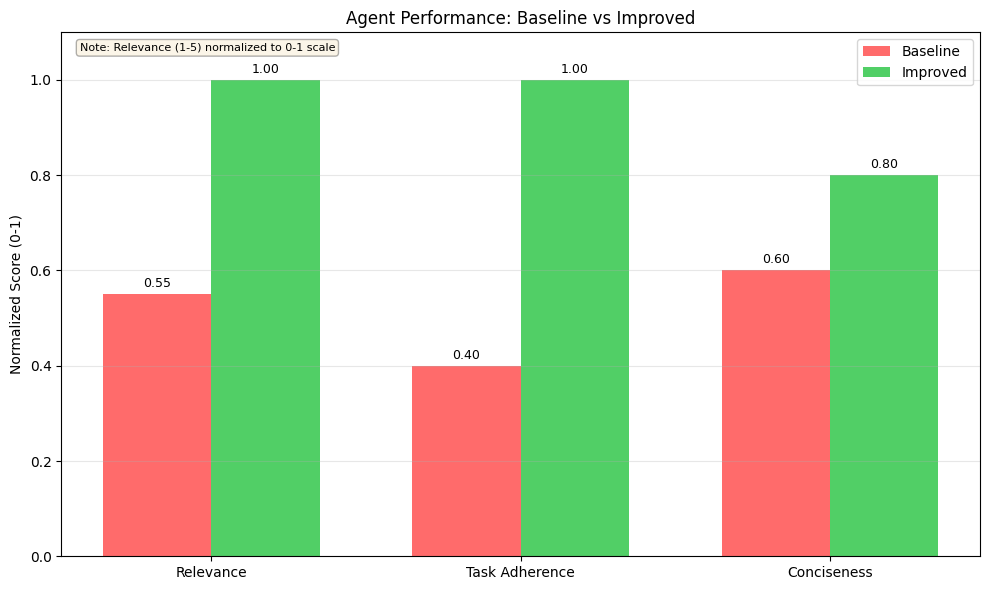

In [58]:
# Visualize comparison (normalized to 0-1 scale)
metrics = list(baseline_eval_results["avg_scores"].keys())

# Normalize scores: Relevance is 1-5, others are 0-1
def normalize_score(metric, score):
    if metric == "relevance":
        return (score - 1) / 4  # Convert 1-5 to 0-1
    return score

baseline_scores = [normalize_score(m, baseline_eval_results["avg_scores"][m]) for m in metrics]
improved_scores = [normalize_score(m, improved_eval_results["avg_scores"][m]) for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='#ff6b6b')
rects2 = ax.bar(x + width/2, improved_scores, width, label='Improved', color='#51cf66')

ax.set_ylabel('Normalized Score (0-1)')
ax.set_title('Agent Performance: Baseline vs Improved')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add value labels showing normalized scores
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

# Add note about normalization
ax.text(0.02, 0.98, 'Note: Relevance (1-5) normalized to 0-1 scale',
        transform=ax.transAxes, fontsize=8, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

## Part G: Analyze Specific Cases

Let's do a deep dive into specific test cases to understand how improvements translate to real responses.

In [63]:
# Comprehensive case-by-case comparison
def analyze_case(idx: int):
    """Display detailed comparison of baseline vs improved for a specific test case."""
    test_case = test_dataset[idx]
    baseline_result = baseline_eval_results["results"][idx]
    improved_result = improved_eval_results["results"][idx]

    print("=" * 80)
    print(f"📋 CASE {idx + 1}: {test_case['category'].upper()}")
    print("=" * 80)
    print(f"\n❓ Query: {test_case['query']}")
    print(f"🎯 Expected: {test_case['expected_outcome']}\n")

    # Baseline Response
    print("─" * 80)
    print("🔴 BASELINE AGENT")
    print("─" * 80)
    print(f"\n💬 Response:\n{baseline_result['response']}\n")

    print("📊 Scores:")
    for metric, score in baseline_result['scores'].items():
        if metric == "relevance":
            print(f"  • {metric.replace('_', ' ').title():18s}: {score:.2f} / 5.00")
        else:
            print(f"  • {metric.replace('_', ' ').title():18s}: {score:.2f} / 1.00")

    print("\n📝 Rationales:")
    for metric, reasoning in baseline_result['reasoning'].items():
        print(f"  • {metric.replace('_', ' ').title()}:")
        # Truncate long rationales
        reasoning_text = reasoning
        print(f"    {reasoning_text}")

    # Improved Response
    print("\n" + "─" * 80)
    print("🟢 IMPROVED AGENT")
    print("─" * 80)
    print(f"\n💬 Response:\n{improved_result['response']}\n")

    print("📊 Scores:")
    for metric, score in improved_result['scores'].items():
        if metric == "relevance":
            print(f"  • {metric.replace('_', ' ').title():18s}: {score:.2f} / 5.00")
        else:
            print(f"  • {metric.replace('_', ' ').title():18s}: {score:.2f} / 1.00")

    print("\n📝 Rationales:")
    for metric, reasoning in improved_result['reasoning'].items():
        print(f"  • {metric.replace('_', ' ').title()}:")
        reasoning_text = reasoning
        print(f"    {reasoning_text}")

    # Score Improvements
    print("\n" + "─" * 80)
    print("📈 IMPROVEMENTS")
    print("─" * 80)
    for metric in baseline_result['scores'].keys():
        baseline_score = baseline_result['scores'][metric]
        improved_score = improved_result['scores'][metric]

        if baseline_score > 0:
            change = ((improved_score - baseline_score) / baseline_score) * 100
            change_str = f"{change:+.1f}%"
        else:
            change_str = "N/A"

        # Show improvement with context
        if metric == "relevance":
            print(f"  • {metric.replace('_', ' ').title():18s}: {baseline_score:.2f} → {improved_score:.2f} ({change_str})")
        else:
            print(f"  • {metric.replace('_', ' ').title():18s}: {baseline_score:.2f} → {improved_score:.2f} ({change_str})")

    print("=" * 80 + "\n")

In [64]:
# Analyze first case
analyze_case(0)

📋 CASE 1: BROWSE

❓ Query: What events are happening on campus?
🎯 Expected: Should call get_events to list all available events

────────────────────────────────────────────────────────────────────────────────
🔴 BASELINE AGENT
────────────────────────────────────────────────────────────────────────────────

💬 Response:
Here are the events happening on campus:

1. **TechFest 2024**
2. **Spring Hackathon 2024**
3. **AI & Machine Learning Workshop**
4. **Robotics Club Demo Day**

Let me know if you would like more details about any of these events!

📊 Scores:
  • Relevance         : 5.00 / 5.00
  • Task Adherence    : 1.00 / 1.00
  • Conciseness       : 1.00 / 1.00

📝 Rationales:
  • Relevance:
    The response directly addresses the user's query about campus events by listing several specific events happening on campus. It provides sufficient detail and invites further inquiry, making it fully relevant and helpful.
  • Task Adherence:
    The assistant successfully provided information a

In [65]:
# Analyze another interesting case (e.g., registration if available)
if len(test_dataset) > 2:
    analyze_case(2)

📋 CASE 3: REGISTRATION

❓ Query: Register me for the AI Workshop. My name is Rahul and ID is S001
🎯 Expected: Should register student with confirmation details

────────────────────────────────────────────────────────────────────────────────
🔴 BASELINE AGENT
────────────────────────────────────────────────────────────────────────────────

💬 Response:
It seems there was an issue with finding the details for the "AI Workshop" event. However, based on the listed events, it appears that the event you're looking for is labeled as "AI & Machine Learning Workshop."

I'll attempt to register you for the "AI & Machine Learning Workshop" again.It seems I'm still unable to register you for the "AI & Machine Learning Workshop." There might be an issue with the event ID or registration system.

Would you like me to check the participants of the event to see if it's still active or look for any other events?

📊 Scores:
  • Relevance         : 2.00 / 5.00
  • Task Adherence    : 0.00 / 1.00
  • Conci

## 🎉 Lab 2 Complete!

### What You Accomplished:

✅ **Created test dataset** with diverse event-focused cases  
✅ **Used Azure AI evaluators** (Relevance, Task Adherence)  
✅ **Built custom evaluator** (Conciseness)  
✅ **Converted traces** for TaskAdherenceEvaluator  
✅ **Ran baseline evaluation** and identified issues  
✅ **Improved agent systematically** with detailed responses  
✅ **Measured improvement** quantitatively

### Key Learnings:

1. **Azure AI Evaluation SDK** - Production-ready evaluators
2. **Custom evaluators** - Code-based for deterministic rules
3. **Trace conversion** - Enable advanced evaluators like TaskAdherence
4. **Systematic improvement** - Measure → Improve → Re-measure
5. **Quantifiable impact** - Metrics enable objective decisions

### Production Best Practices:

1. Expand test dataset to 50-100 cases per capability
2. Add more evaluators (Groundedness, Safety, Fluency)
3. Automate evaluation in CI/CD pipeline
4. Monitor production metrics continuously
5. A/B test improvements before deployment

---



## 🚀 Extension Challenge (Optional)

Want to practice what you've learned? Try evaluating agents for the **venue booking** and **notification** scenarios from the mock backend!



### Challenge 1: Venue Booking Agent

**Tools to implement:**
- `get_venues()` - List available venues
- `get_venue_availability(venue_id, date)` - Check availability
- `book_venue(venue_id, club_name, date, time_slot, purpose, attendees)` - Book venue

**Test dataset ideas:**
- Browse all venues
- Check specific venue availability
- Book venue with all details
- Handle booking conflicts
- Multi-step: browse → check → book

**Tools to implement:**
- `get_venues()` - List available venues
- `get_venue_availability(venue_id, date)` - Check availability
- `book_venue(venue_id, club_name, date, time_slot, purpose, attendees)` - Book venue

**Test dataset ideas:**
- Browse all venues
- Check specific venue availability
- Book venue with all details
- Handle booking conflicts
- Multi-step: browse → check → book

### Challenge 2: Notification Agent

**Tools to implement:**
- `send_event_notification(event_id, message)` - Send to event participants
- (Could extend with: list notification history, send targeted notifications)

**Test dataset ideas:**
- Send event reminders
- Send venue change notifications
- Send cancellation notices
- Handle invalid event IDs

### Challenge 3: Unified Campus Agent

Combine all three domains (events, venues, notifications) into one agent:
- Import tools from Labs 1 & 2
- Create unified instructions covering all capabilities
- Build comprehensive test dataset (20+ cases)
- Evaluate cross-domain query handling

**Example queries:**
- "Register me for AI Workshop and book Seminar Hall B for our club meeting"
- "Show me events, then notify TechFest participants about the venue change"

### Evaluation Tips:

- Reuse the evaluation framework from this lab
- Consider domain-specific evaluators (e.g., "ParameterExtraction" for venue booking)
- Test edge cases: conflicts, missing data, invalid IDs
- Measure improvement iterations

**Happy evaluating! 🎯**

### **Congratulations on completing the workshop! 🚀**